- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

## Chapter 9 - Hierarchical Models

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec
from scipy.stats import mode

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 45)

%matplotlib inline
plt.style.use('seaborn-white')

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

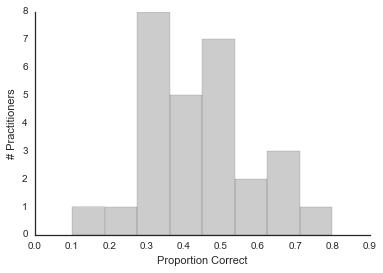

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

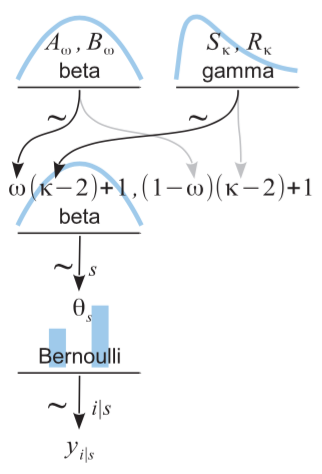

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
le = preprocessing.LabelEncoder()

practitioner_idx = le.fit_transform(df.s)
practitioner_codes = le.classes_
n_practitioners = len(le.classes_)

with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2

    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=n_practitioners)
    
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [6]:
with hierarchical_model:
    step = pmc.NUTS()
     
    trace= pmc.sample(20000, step)

 [-----------------100%-----------------] 20000 of 20000 complete in 157.2 sec

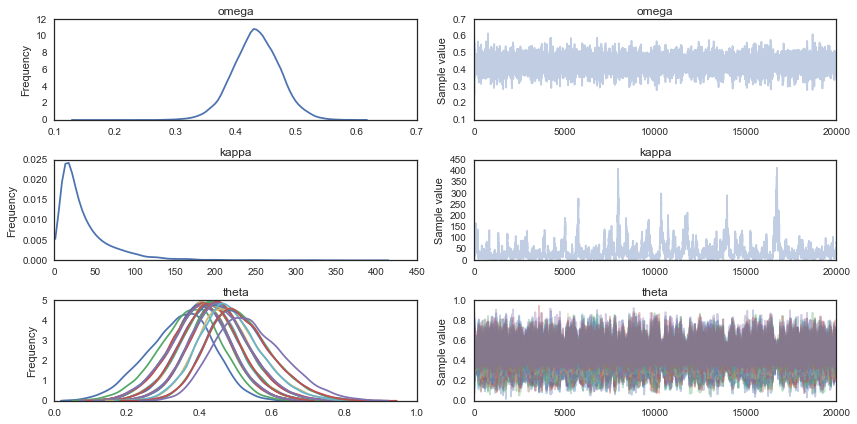

In [7]:
pmc.traceplot(trace);

In [8]:
pmc.df_summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

                mean         sd  mc_error   hpd_2.5    hpd_97.5
omega       0.434222   0.038973  0.000436  0.355306    0.509050
kappa      38.513267  38.988974  2.569599  2.147683  108.973270
theta__0    0.345672   0.092346  0.002673  0.150880    0.509544
theta__1    0.373834   0.088128  0.001885  0.190850    0.536158
theta__2    0.401472   0.085298  0.001096  0.225642    0.563673
theta__3    0.401623   0.084942  0.001138  0.229554    0.566219
theta__4    0.400875   0.084947  0.001188  0.222432    0.558169
theta__5    0.400208   0.085209  0.001170  0.228336    0.565972
theta__6    0.401199   0.084731  0.001110  0.233957    0.571755
theta__7    0.401072   0.085213  0.001185  0.231506    0.571612
theta__8    0.401176   0.085830  0.001176  0.232060    0.575905
theta__9    0.401384   0.086151  0.001170  0.231620    0.574047
theta__10   0.429277   0.085343  0.000653  0.252045    0.596228
theta__11   0.428661   0.085007  0.000646  0.255755    0.597096
theta__12   0.428497   0.085092  0.00062

#### Marginal posterior distributions

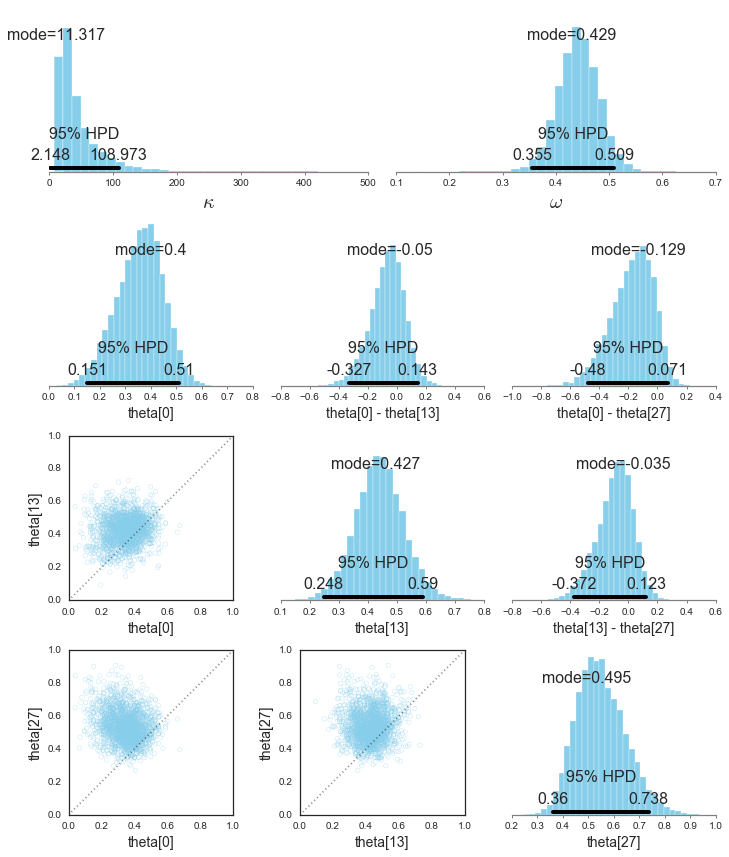

In [9]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

font_d = {'size':14}
color = '#87ceeb'

# kappa posterior plot
pmc.plot_posterior(trace['kappa'], point_estimate='mode', ax=ax1, color=color)
ax1.set(xlim=(0,500))
ax1.set_xlabel('$\kappa$', fontdict={'size':20, 'weight':'bold'})

# omega posterior plot
pmc.plot_posterior(trace['omega'], point_estimate='mode', ax=ax2, color=color)
ax2.set_xlabel('$\omega$', fontdict={'size':20, 'weight':'bold'})

# theta posterior plots
pmc.plot_posterior(trace['theta'][:,0], point_estimate='mode', ax=ax3, color=color)
ax3.set_xlabel('theta[0]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13], point_estimate='mode', ax=ax7, color=color)
ax7.set_xlabel('theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,27], point_estimate='mode', ax=ax11, color=color)
ax11.set_xlabel('theta[27]', fontdict=font_d)

# theta scatter plots
ax6.scatter(trace['theta'][::10,0], trace['theta'][::10,13], alpha=0.75, color=color, facecolor='none')
ax6.plot([0, 1], [0, 1], ':k', transform=ax6.transAxes, alpha=0.5)
ax6.set_xlabel('theta[0]', fontdict=font_d)
ax6.set_ylabel('theta[13]', fontdict=font_d)

ax9.scatter(trace['theta'][::10,0], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax9.plot([0, 1], [0, 1], ':k', transform=ax9.transAxes, alpha=0.5)
ax9.set_xlabel('theta[0]', fontdict=font_d)
ax9.set_ylabel('theta[27]', fontdict=font_d)

ax10.scatter(trace['theta'][::10,13], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax10.plot([0, 1], [0, 1], ':k', transform=ax10.transAxes, alpha=0.5)
ax10.set_xlabel('theta[13]', fontdict=font_d)
ax10.set_ylabel('theta[27]', fontdict=font_d)

for ax in [ax6, ax9, ax10]:
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal') 
    
# theta posterior differences plots
pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,14], point_estimate='mode', ax=ax4, color=color)
ax4.set_xlabel('theta[0] - theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,27], point_estimate='mode', ax=ax5, color=color)
ax5.set_xlabel('theta[0] - theta[27]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13]-trace['theta'][:,27], point_estimate='mode', ax=ax8, color=color)
ax8.set_xlabel('theta[13] - theta[27]', fontdict=font_d)

plt.tight_layout();

### 9.5.1 - Example: Baseball batting abilities by position

In [2]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null object
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: int64(2), object(2)
memory usage: 29.7+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [3]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

           Player      PriPos  Hits  AtBats     BatAv
0   Fernando Abad     Pitcher     1       7  0.142857
1     Bobby Abreu  Left Field    53     219  0.242009
2      Tony Abreu    2nd Base    18      70  0.257143
3   Dustin Ackley    2nd Base   137     607  0.225700
4      Matt Adams    1st Base    21      86  0.244186
5   Nathan Adcock     Pitcher     0       1  0.000000
6  Jeremy Affeldt     Pitcher     0       1  0.000000
7   Brandon Allen    1st Base     2      20  0.100000
8   Yonder Alonso    1st Base   150     549  0.273224
9     Jose Altuve    2nd Base   167     576  0.289931

#### Model (Kruschke, 2015)

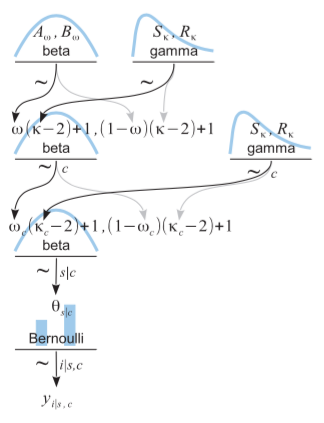

In [12]:
Image('images/fig9_13.png', width=400)

In [35]:
le = preprocessing.LabelEncoder()

# Encode the 9 primary field positions
pripos_idx = le.fit_transform(df2.PriPos)
pripos_codes = le.classes_
n_pripos = len(le.classes_)

# df2 contains one entry per player
players_idx = le.fit_transform(df2.Player)    # Not really needed, since we have 1 record per player
n_players = len(le.classes_)

with pmc.Model() as hierarchical_model2:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2 
    
    omega_c = pmc.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c = pmc.Gamma('kappa_c',
                        0.01, 0.01,
                        shape = n_pripos)+2

    theta = pmc.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1, (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y = pmc.Binomial('y', n=df2.AtBats.as_matrix(), p=theta[players_idx], observed=df2.Hits)

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to omega_c and added transformed omega_c_logodds_ to model.
Applied log-transform to kappa_c and added transformed kappa_c_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [37]:
with hierarchical_model2:
    step = pmc.NUTS()
    trace = pmc.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 1311.5 sec

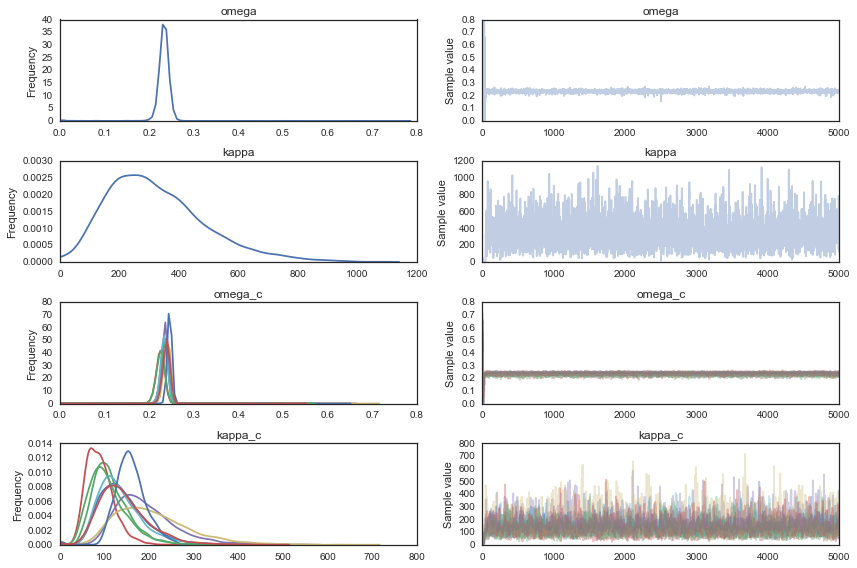

In [38]:
pmc.traceplot(trace, varnames=['omega', 'kappa', 'omega_c', 'kappa_c']);

In [39]:
pmc.df_summary(trace)

                  mean          sd  mc_error    hpd_2.5    hpd_97.5
omega         0.232030    0.022484  0.000993   0.213757    0.253266
kappa       325.528486  168.477244  4.094880  51.963814  676.858559
omega_c__0    0.233136    0.010996  0.000275   0.217590    0.247586
omega_c__1    0.234492    0.012612  0.000448   0.218799    0.251028
omega_c__2    0.224315    0.014498  0.000397   0.206152    0.241474
omega_c__3    0.234743    0.011957  0.000385   0.222901    0.245970
omega_c__4    0.239971    0.015307  0.000445   0.226590    0.254848
omega_c__5    0.232557    0.011786  0.000390   0.218354    0.246219
omega_c__6    0.244467    0.018545  0.001104   0.237871    0.252919
omega_c__7    0.224707    0.012671  0.000314   0.205760    0.243137
omega_c__8    0.237638    0.015072  0.000647   0.223085    0.253589
kappa_c__0  140.724798   54.120013  2.120310  48.721048  246.445269
kappa_c__1  114.530160   41.987164  1.705364  44.895992  197.313658
kappa_c__2   89.189499   31.276018  1.404793  36

##### Posterior distributions of the omega_c parameters after sampling. Way too similar?!

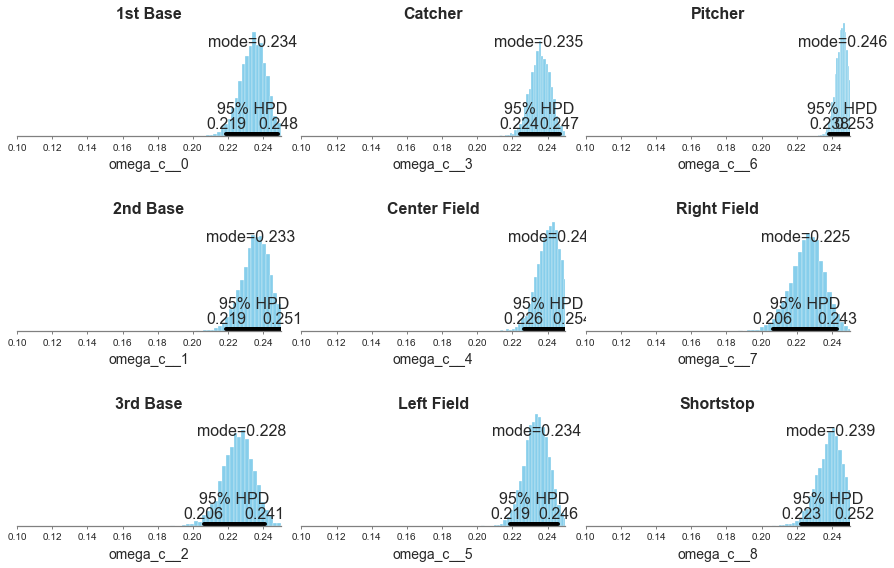

In [43]:
fig, axes = plt.subplots(3,3, figsize=(12,8))
for i, ax in enumerate(axes.T.flatten()):
    pmc.plot_posterior(trace['omega_c'][100:,i], ax=ax, point_estimate='mode', color='#87ceeb')
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.1,0.25)
plt.tight_layout(h_pad=3)

##### The below image from the book shows the __omega_c__ distributions obtained by JAGS/R

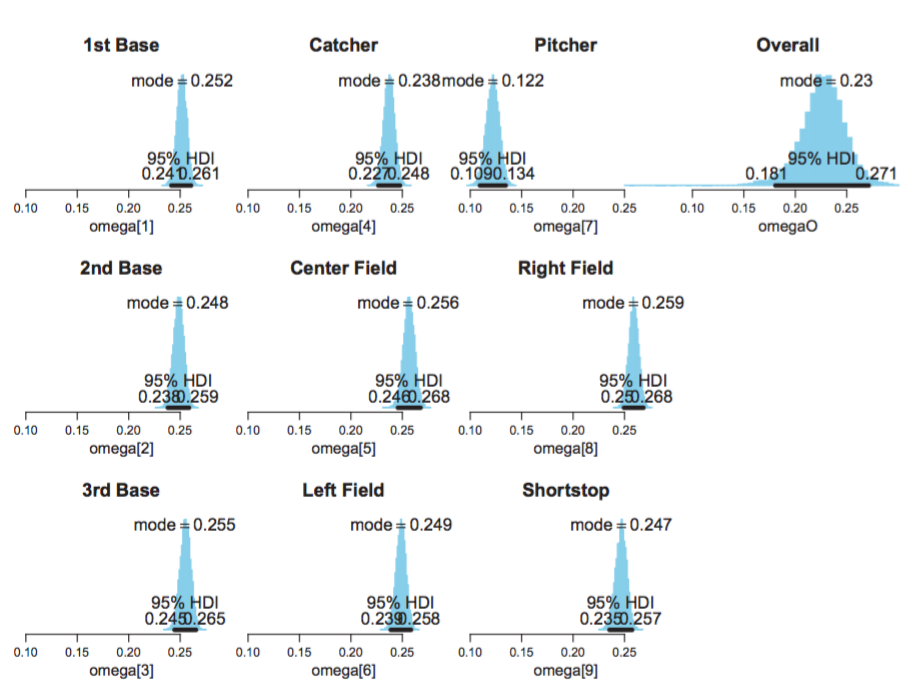

In [45]:
Image('images/fig9_17.png')